### A Function to Display the Letters in a Grid

In [10]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Function to display all letters stored in the resized_letters list
def display_letters(resized_letters):

    # Set up the figure for displaying multiple images
    num_letters = len(resized_letters)
    cols = 5  # Number of columns to display (you can change this based on how many images you want per row)
    rows = (num_letters + cols - 1) // cols  # Calculate number of rows needed
    plt.figure(figsize=(cols * 2, rows * 2))  # Set the figure size based on the number of images

    # Iterate through the list of resized letters and display each one
    for i, letter in enumerate(resized_letters):
        plt.subplot(rows, cols, i + 1)  # Create a subplot for each letter
        plt.imshow(letter, cmap='gray')
        plt.title(f'Letter {i+1}')
        plt.axis('off') # Hide axis
    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()


### A Function to Segment Each Letter Using Contours 

In [13]:
def contour_detection(image_path):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Invert the image so the text becomes white and the background becomes black
    inverted_image = cv2.bitwise_not(image)

    # Define a 3x3 kernel
    kernel = np.ones((3, 3), np.uint8)

    # Display the inverted image
    plt.figure(figsize=(2, 2))
    plt.imshow(inverted_image, cmap='gray')
    plt.title(f'Inverted Image')
    plt.axis('off')
    plt.show()

    # Perform dilation on the inverted image
    dilated_image = cv2.dilate(inverted_image, kernel, iterations=1)

    # Display the dialated 
    plt.figure(figsize=(2, 2))
    plt.imshow(dilated_image, cmap='gray')
    plt.title(f'Dilated Image')
    plt.axis('off')
    plt.show()

    # Invert back to original colors (if needed)
    final_image = cv2.bitwise_not(dilated_image)

    # Binarize the image with a higher threshold to reduce sensitivity
    _, binary_image = cv2.threshold(final_image, 100, 255, cv2.THRESH_BINARY_INV)

    # Find contours for character segmentation
    char_contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a copy of the image to draw bounding boxes
    character_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)

    # List to store character bounding boxes
    char_bounding_boxes = []
    for contour in char_contours:
        x, y, w, h = cv2.boundingRect(contour)
        # Filter out small contours to reduce noise
        if w > 10 and h > 10:
            char_bounding_boxes.append((x, y, w, h))

    # Step 1: Sort by Y-coordinate (top to bottom) first to group lines
    char_bounding_boxes = sorted(char_bounding_boxes, key=lambda box: box[1])

    # Step 2: Group contours that are on the same line based on their y-coordinates
    line_threshold = 20  # Adjust this based on the spacing between lines
    lines = []
    current_line = []
    previous_y = char_bounding_boxes[0][1]  # Initialize with the y-coordinate of the first contour

    for box in char_bounding_boxes:
        x, y, w, h = box
        if abs(y - previous_y) < line_threshold:
            current_line.append(box)  # Same line
        else:
            lines.append(current_line)  # Start a new line
            current_line = [box]
        previous_y = y

    # Add the last line
    if current_line:
        lines.append(current_line)

    # Step 3: Sort each line's bounding boxes by X-coordinate (left to right)
    for line in lines:
        line.sort(key=lambda box: box[0])

    # Step 4: Draw bounding boxes and print letters in the correct order
    for line in lines:
        for (x, y, w, h) in line:
            # Draw character bounding boxes in blue
            cv2.rectangle(character_image, (x, y), (x + w, y + h), (255, 0, 0), 2)

    # Display the image with bounding boxes around characters
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(character_image, cv2.COLOR_BGR2RGB))
    plt.title('Character Segmentation')
    plt.axis('off')
    plt.show()

    
    # List to hold the identified letters
    resized_letters = []

    # Step 5: Crop and display each letter in the correct order (left-to-right, top-to-bottom)
    for line in lines:
        for i, (x, y, w, h) in enumerate(line):
            # Crop the letter from the original image
            letter_crop = image[y:y+h, x:x+w]

            # Calculate number of pixels in the cropped region
            # num_pixels = np.sum(letter_crop > 0)  # Count non-zero pixels

            # Display the cropped letter with the number of pixels
            # plt.figure(figsize=(2, 2))
            # plt.imshow(letter_crop, cmap='gray')
            # plt.title(f'Letter {i+1}\nPixels: {num_pixels}')
            # plt.axis('off')
            # plt.show()

            # Resize the cropped letter to 80x80 pixels
            resized_letter = cv2.resize(letter_crop, (80, 80), interpolation=cv2.INTER_AREA)

            # Append the hence resized letter to the resized_letters list. (To be fed into the google translator api lator on)
            resized_letters.append(resized_letter)

            # calculate the number of pixels in the resized region 
            # num_pixels_resized = np.sum(resized_letter > 0) # Count non-zero pixels

            # Display the resized letter 
            # plt.figure(figsize=(2, 2))
            # plt.imshow(resized_letter, cmap='gray')
            # plt.title(f'Resized Letter {i+1} Pixels: {num_pixels_resized}')
            # plt.axis('off')
            # plt.show()
            
    # Call the function with the list of resized letters
    # display_letters(resized_letters)
    return resized_letters

### Function to Classify a List of Processed, Segmented Images

In [32]:
# Function to classify a list of preprocessed images
def classify_images(model, images, label_encoder):
    # Ensure images are preprocessed (normalized, resized, channel dimension added)
    print("In classify function:")
    print(len(images))
    predictions = model.predict(images)
    
    # Get the class labels (using argmax to get the index of the class with the highest probability)
    predicted_indices = np.argmax(predictions, axis=1)
    
    # Decode the predicted labels
    predicted_labels = label_encoder.inverse_transform(predicted_indices)
    
    return predicted_labels

### Main Deployable Function

In [34]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder

def deploy_model(image_list, model_path, label_encoder_path):
    # Load the trained model
    model = load_model(model_path)
    
    # Load the label encoder
    label_encoder = LabelEncoder()
    label_encoder.classes_ = np.load(label_encoder_path)
    
    # Preprocess the images (ensure the correct shape for the model)
    image_list = np.array(image_list)  # Convert list of images to a numpy array
    image_list = np.expand_dims(image_list, axis=-1)  # Add channel dimension (1 for grayscale)
    
    # Ensure the image shape is (N, 80, 80, 1)
    if len(image_list.shape) == 3:  # Check if shape is (N, 80, 80)
        image_list = np.expand_dims(image_list, axis=-1)  # Add the channel dimension
    
    # Normalize the images (assuming the model expects input in the range [0, 1])
    image_list = image_list / 255.0

    # Classify the preprocessed images
    predictions = model.predict(image_list)
    
    # Get the class labels (using argmax to get the index of the class with the highest probability)
    predicted_indices = np.argmax(predictions, axis=1)
    
    # Convert indices back to original class labels
    predicted_labels = label_encoder.inverse_transform(predicted_indices)
    
    return predicted_labels


### Loading the CNN and Weights

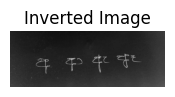

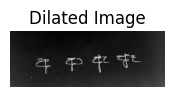

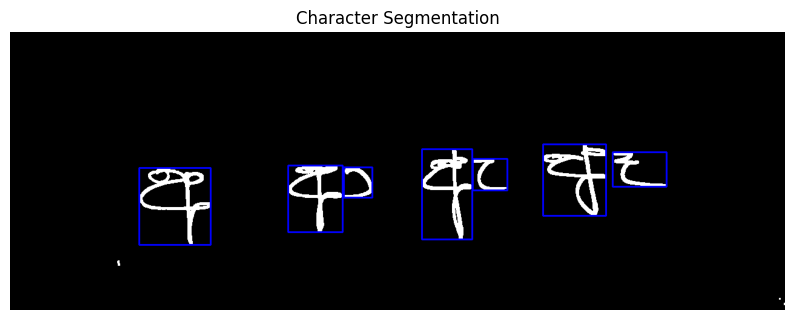

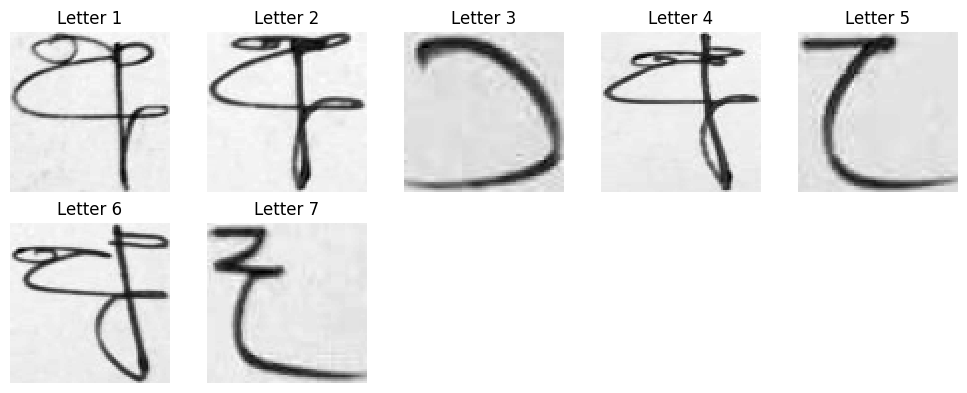

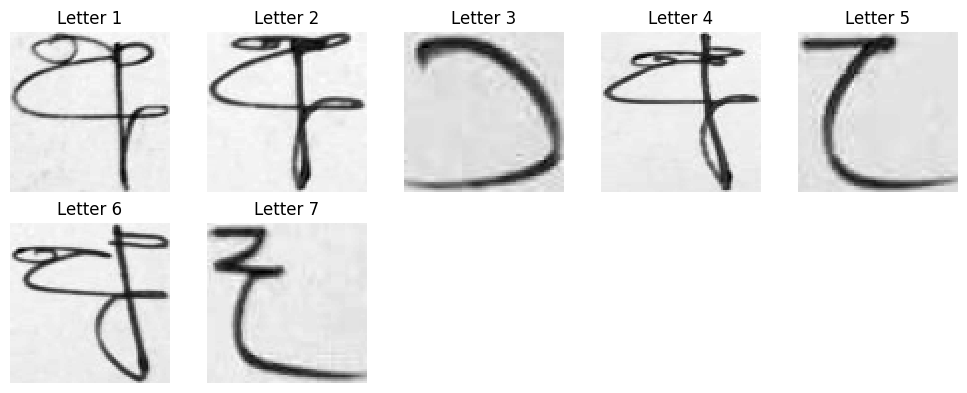

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
Letter 1: 414
Letter 2: 414
Letter 3: 402
Letter 4: 402
Letter 5: 402
Letter 6: 402
Letter 7: 402


In [35]:
# Example usage of deployable function
if __name__ == "__main__":
    # Load or generate the list of images (e.g., after contour detection)
    image_path = 'C:/Users/cmsmc/Desktop/Projects/SinhalaTranslator/Work/code/CNN/Development/SampleImages/letters.jpg'
    
    # Assuming `contour_detection` is a function that returns a list of letter images from the original image
    letters = contour_detection(image_path=image_path)  # This should return a list of segmented letter images

    display_letters(letters)

    # Define model and label encoder paths
    model_path = './TrainedModels/CNN_trial_1.keras'
    label_encoder_path = './TrainedModels/CNN_trial_1_classes.npy'
    
    # Deploy the model and classify the letters
    predictions = deploy_model(letters, model_path, label_encoder_path)
    
    # Print the predictions for each letter
    for i, prediction in enumerate(predictions):
        print(f'Letter {i+1}: {prediction}')

### Performing Predictions

### Implementation

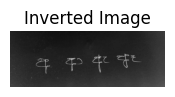

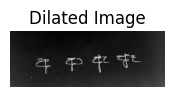

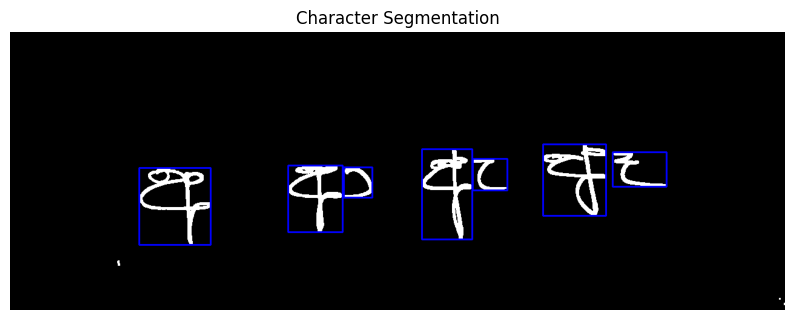

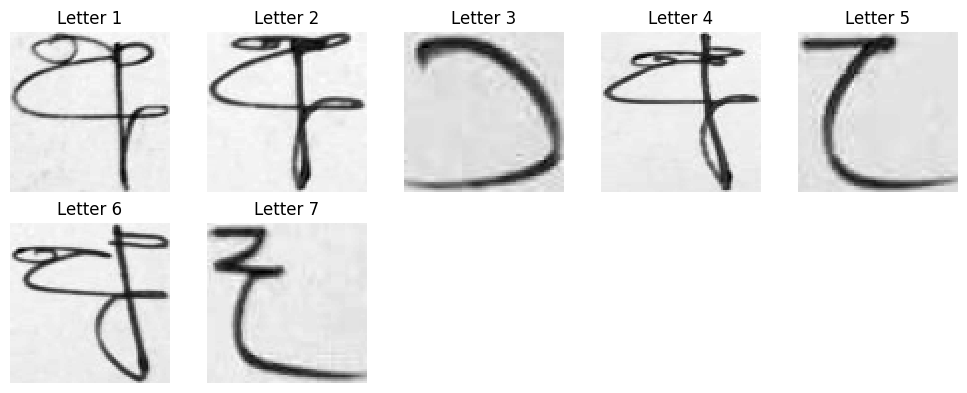

In [8]:
letters_list = []
letters_list = contour_detection(image_path="C:/Users/cmsmc/Desktop/Projects/SinhalaTranslator/Work/code/CNN/Development/SampleImages/letters.jpg")